# Hungary HICP vs LCI Analysis (2000-2024)

This notebook extracts, aligns, and plots Hungary's Harmonised Index of Consumer Prices (HICP) and Labour Cost Index (LCI) data. 
It implements specific logic to align the monthly HICP data with the quarterly LCI data by selecting the first month of each quarter.

In [ ]:
import eurostat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from statsmodels.tsa.stattools import adfuller

%matplotlib inline

print("Libraries Imported.")

## Helper Functions
Functions to fetch data (with caching), parse dates robustly, and extract specific time series.

In [ ]:
def fetch_data(dataset_code):
    cache_file = f"{dataset_code}.csv"
    if os.path.exists(cache_file):
        return pd.read_csv(cache_file, low_memory=False)
    else:
        return eurostat.get_data_df(dataset_code)

def get_geo_col(df):
    candidates = [c for c in df.columns if 'geo' in c.lower()]
    return candidates[0] if candidates else None

def parse_dates_robust(index_obj):
    s = index_obj.astype(str).str.upper().str.strip()
    # Map Quarters to Month starts
    s = s.str.replace('Q1', '01', regex=False).str.replace('Q2', '04', regex=False).str.replace('Q3', '07', regex=False).str.replace('Q4', '10', regex=False)
    # Remove separators
    s = s.str.replace('M', '', regex=False).str.replace('-', '', regex=False).str.replace('_', '', regex=False).str.replace(' ', '', regex=False)
    return pd.to_datetime(s, format='%Y%m', errors='coerce')

def extract_series(dataset_code, geo_filter, unit_list, cat_col, cat_list, start_year, end_year):
    df = fetch_data(dataset_code)
    geo_col = get_geo_col(df)
    
    # Filters
    df = df[df[geo_col] == geo_filter]
    
    # Unit Filter
    if 'unit' in df.columns:
        found = False
        for u in unit_list:
            if u in df['unit'].values:
                df = df[df['unit'] == u]
                found = True
                break
                
    # Category Filter
    if cat_col and cat_col in df.columns:
        found = False
        for c in cat_list:
            if c in df[cat_col].values:
                df = df[df[cat_col] == c]
                found = True
                break
    
    if df.empty: return None, "Empty after filters"

    # Time Cols
    time_cols = [col for col in df.columns if len(col) > 0 and col[0].isdigit()]
    if not time_cols: return None, "No time columns"
        
    df_series = df[time_cols].T
    df_series.index = parse_dates_robust(df_series.index)
    
    # Filter Year
    df_series = df_series[(df_series.index.year >= start_year) & (df_series.index.year <= end_year)]
    
    if df_series.empty: return None, "Empty after date filter"

    # Data
    s_data = df_series.iloc[:, 0]
    s_data = pd.to_numeric(s_data, errors='coerce').dropna()
    
    return s_data, "Success"

## Extract & Align Data
1. Extract HICP (Monthly) and LCI (Quarterly) Series.
2. Determine common time range.
3. Subset HICP data to match LCI quarters (selecting matching months).

In [ ]:
# Extract Series (keeping index for plotting)
hicp_series, msg_hicp = extract_series('prc_hicp_midx', 'HU', ['I15'], 'coicop', ['CP00'], 1990, 2020)
lci_series, msg_lci = extract_series('lc_lci_r2_q', 'HU', ['I15', 'I20'], 'nace_r2', ['B-S'], 1990, 2020)

# Get Arrays (Initial)
hicp_vals_initial = hicp_series.values if hicp_series is not None else None
lci_vals_initial = lci_series.values if lci_series is not None else None

# ALIGNMENT LOGIC
if hicp_series is not None and lci_series is not None:
    # Find common date range
    start_date = max(hicp_series.index.min(), lci_series.index.min())
    end_date = min(hicp_series.index.max(), lci_series.index.max())
    
    print(f"--- Aligning Series ---")
    print(f"Common Start Date: {start_date.date()}")
    print(f"Common End Date:   {end_date.date()}")
    
    # Slice both to this range
    hicp_series = hicp_series[(hicp_series.index >= start_date) & (hicp_series.index <= end_date)]
    lci_series = lci_series[(lci_series.index >= start_date) & (lci_series.index <= end_date)]
    
    # RESAMPLING: Drop values between a quarter
    # Selects the Month corresponding to the Quarter start.
    print(f"Selecting HICP values matching LCI quarters (dropping intermediate months)...")
    
    # Ensure they are exactly the same size/index intersection
    common_idx = hicp_series.index.intersection(lci_series.index)
    hicp_series = hicp_series.loc[common_idx]
    lci_series = lci_series.loc[common_idx]
    
    hicp_vals = hicp_series.values
    lci_vals = lci_series.values
else:
    hicp_vals = hicp_vals_initial
    lci_vals = lci_vals_initial

print("\n--- RESULTS (Aligned & Subset) ---")
if hicp_vals is not None:
    print(f"HICP Array Shape: {hicp_vals.shape}")
    print(f"First 10: {hicp_vals[:10]}")

if lci_vals is not None:
    print(f"LCI Array Shape: {lci_vals.shape}")
    print(f"First 10: {lci_vals[:10]}")

## Plotting
Visualizing the aligned data arrays.

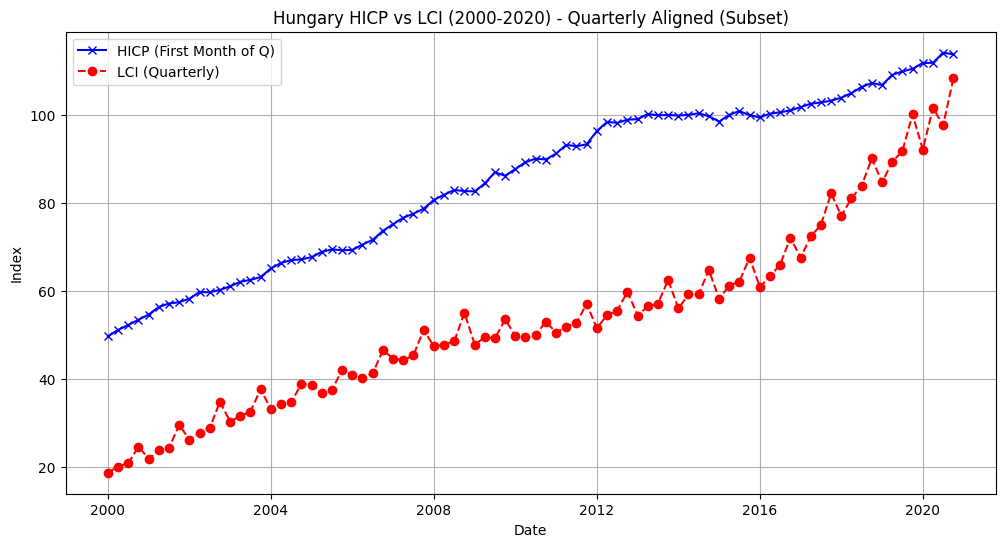

In [44]:
if hicp_series is not None and lci_series is not None:
    plt.figure(figsize=(12, 6))
    
    # Plot using the series index (dates) so they align correctly
    plt.plot(hicp_series.index, hicp_vals, label='HICP (First Month of Q)', color='blue', marker='x', linestyle='-')
    plt.plot(lci_series.index, lci_vals, label='LCI (Quarterly)', color='red', marker='o', linestyle='--')
    
    plt.title(f"Hungary HICP vs LCI ({start_date.year}-{end_date.year}) - Quarterly Aligned (Subset)")
    plt.xlabel("Date")
    plt.ylabel("Index")
    plt.grid(True)
    plt.legend()
    plt.show()
else:
    print("Cannot plot: one or both series missing.")

## Growth Rate Analysis & Stationarity (ADF Test)
Calculating logarithmic growth rates and performing the Augmented Dickey-Fuller test.
To achieve a stationary series (p-value < 0.05), we must test the **Differenced (Growth)** series.

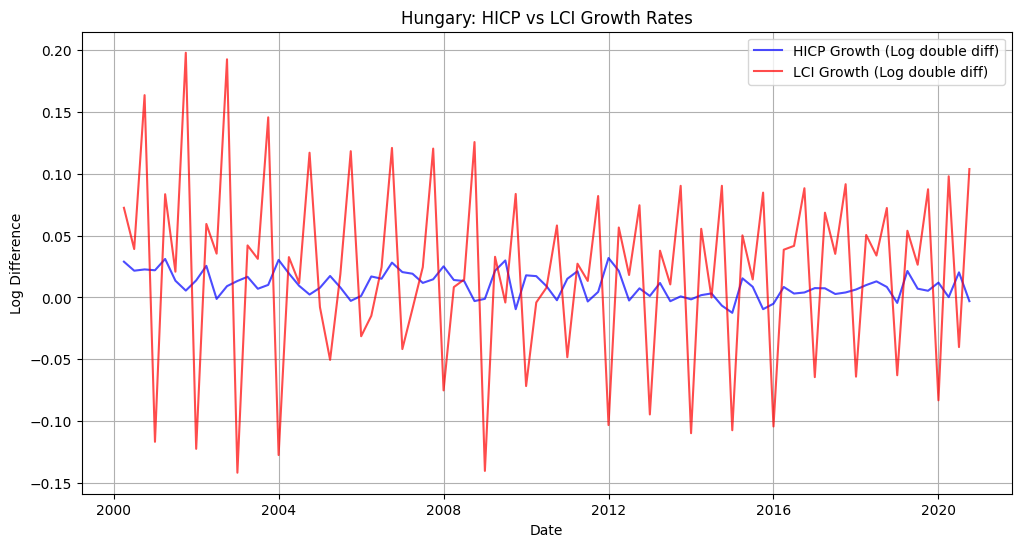


--- Augmented Dickey-Fuller Test Results ---

[HICP Growth]
ADF Statistic: -2.8797
p-value:       4.7759e-02
Stationary?    YES (p<0.05)

[LCI Growth]
ADF Statistic: -2.1834
p-value:       2.1234e-01
Stationary?    NO (High p-value)


In [46]:
if hicp_series is not None and lci_series is not None:
    # Calculate Log Difference (Growth Rate)
    hicp_growth = np.log(hicp_series).diff().dropna()
    lci_growth = np.log(lci_series).diff().dropna()

    # --- PLOT GROWTH RATES ---
    plt.figure(figsize=(12, 6))
    plt.plot(hicp_growth.index, hicp_growth, label='HICP Growth (Log double diff)', color='blue', alpha=0.7)
    plt.plot(lci_growth.index, lci_growth, label='LCI Growth (Log double diff)', color='red', alpha=0.7)
    plt.title("Hungary: HICP vs LCI Growth Rates")
    plt.xlabel("Date")
    plt.ylabel("Log Difference")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # --- ADF TEST ---
    print("\n--- Augmented Dickey-Fuller Test Results ---")
    
    def print_adf(name, series):
        result = adfuller(series.values)
        print(f"\n[{name}]")
        print(f"ADF Statistic: {result[0]:.4f}")
        print(f"p-value:       {result[1]:.4e}")
        is_stationary = result[1] < 0.05
        print(f"Stationary?    {'YES (p<0.05)' if is_stationary else 'NO (High p-value)'}")

    print_adf("HICP Growth", hicp_growth)
    print_adf("LCI Growth", lci_growth)
    
else:
    print("Data missing for growth calculation.")

In [53]:
from statsmodels.tsa.stattools import grangercausalitytests
granger_lci_hicp = grangercausalitytests(np.vstack([hicp_growth, lci_growth]).T, maxlag=4)
#it seems that with lag 3 the p-value is the lowest


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9617  , p=0.3297  , df_denom=79, df_num=1
ssr based chi2 test:   chi2=0.9982  , p=0.3177  , df=1
likelihood ratio test: chi2=0.9922  , p=0.3192  , df=1
parameter F test:         F=0.9617  , p=0.3297  , df_denom=79, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.0225  , p=0.0546  , df_denom=76, df_num=2
ssr based chi2 test:   chi2=6.4428  , p=0.0399  , df=2
likelihood ratio test: chi2=6.1994  , p=0.0451  , df=2
parameter F test:         F=3.0225  , p=0.0546  , df_denom=76, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.6682  , p=0.0049  , df_denom=73, df_num=3
ssr based chi2 test:   chi2=15.3474 , p=0.0015  , df=3
likelihood ratio test: chi2=14.0400 , p=0.0029  , df=3
parameter F test:         F=4.6682  , p=0.0049  , df_denom=73, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.7584  , p=0.1470  , df_d

In [ ]:
granger_hicp_lci = grangercausalitytests(np.vstack([lci_growth, hicp_growth]).T, maxlag=4)
#it seems that with lag 2 the p-value is the lowest


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4753  , p=0.2281  , df_denom=79, df_num=1
ssr based chi2 test:   chi2=1.5314  , p=0.2159  , df=1
likelihood ratio test: chi2=1.5172  , p=0.2180  , df=1
parameter F test:         F=1.4753  , p=0.2281  , df_denom=79, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=9.5846  , p=0.0002  , df_denom=76, df_num=2
ssr based chi2 test:   chi2=20.4303 , p=0.0000  , df=2
likelihood ratio test: chi2=18.2187 , p=0.0001  , df=2
parameter F test:         F=9.5846  , p=0.0002  , df_denom=76, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.6939  , p=0.0047  , df_denom=73, df_num=3
ssr based chi2 test:   chi2=15.4321 , p=0.0015  , df=3
likelihood ratio test: chi2=14.1111 , p=0.0028  , df=3
parameter F test:         F=4.6939  , p=0.0047  , df_denom=73, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.1527  , p=0.3392  , df_d

## Vector Autoregression (VAR) & Impulse Response
Fit a VAR model to the stationary growth rates and analyze the Impulse Response Functions (IRF).

c:\Users\Csongor\Documents\BME\Kauzalitas\Causality_project\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)



--- Impulse Response Functions ---


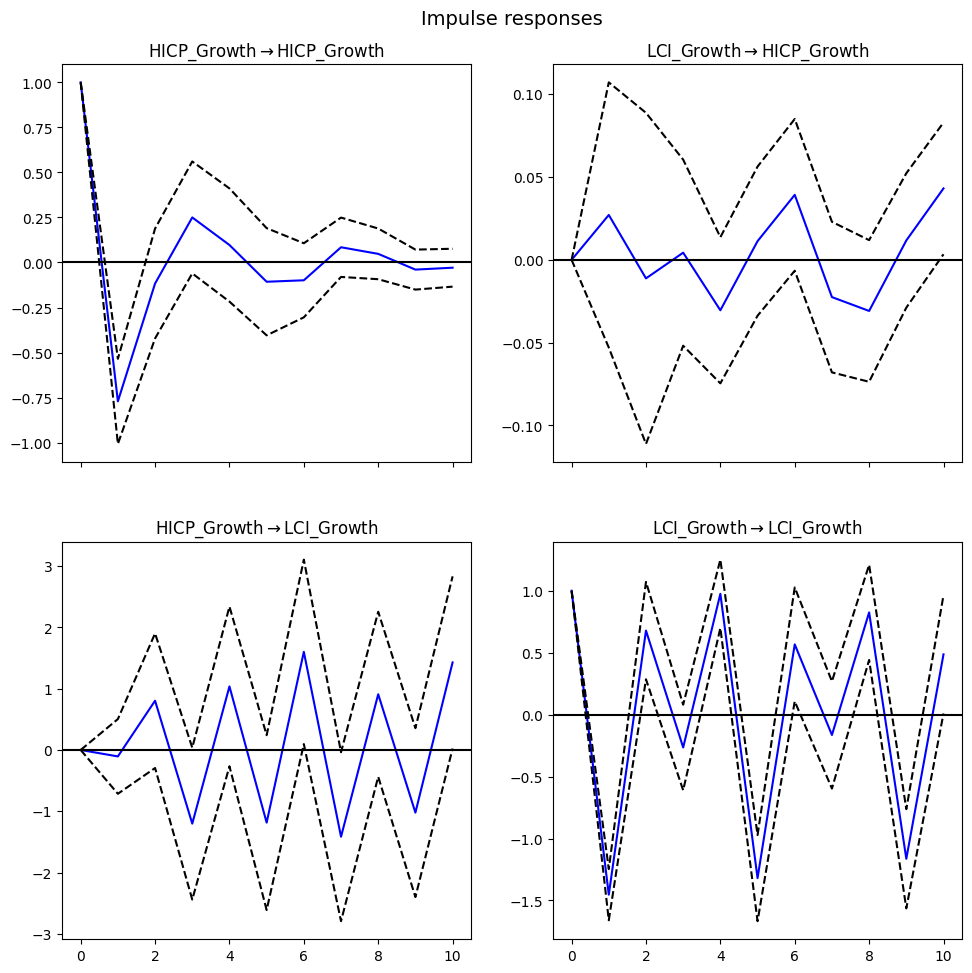

In [43]:
from statsmodels.tsa.api import VAR

if hicp_series is not None and lci_series is not None:
    # Prepare Data for VAR
    data = pd.DataFrame({'HICP_Growth': hicp_growth, 'LCI_Growth': lci_growth}).dropna()
    
    # Fit Model (selecting lag order automatically)
    model = VAR(data)
    results = model.fit(maxlags=15, ic='aic')
    # print(results.summary())
    
    # Impulse Response Analysis
    irf = results.irf(10)
    
    print("\n--- Impulse Response Functions ---")
    # Semicolon suppresses the return value object, preventing double plotting
    irf.plot(); 
    plt.show()
else:
    print("Data missing for VAR analysis.")